# A Quick Introduction to Clustering with Iris Data

In [1]:
import pandas as pd, numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import load_iris

In [2]:
iris = load_iris()

In [4]:
X = iris.data
y = iris.target

In [6]:
km = KMeans(init="random", n_clusters=5)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [7]:
km.labels_

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, 2,
       1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, 2, 2, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 2, 1, 1, 4, 2, 0, 4, 4, 0, 1, 0, 4, 0, 4, 4, 4, 2, 4,
       4, 4, 0, 0, 2, 4, 2, 0, 2, 4, 0, 2, 2, 4, 0, 0, 0, 4, 2, 2, 0, 4, 4,
       2, 4, 4, 4, 2, 4, 4, 4, 2, 4, 4, 2], dtype=int32)

# Synthetic data for testing clustering algorithms

We'll import (and plot) pre-generated synthetic data which captures a wide range of spatial distribution so that we can apply clustering algoriths on it to see where the algorithm fares well and where it does badly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.cluster as cluster
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

In [2]:
data = np.load('clusterable_data.npy')

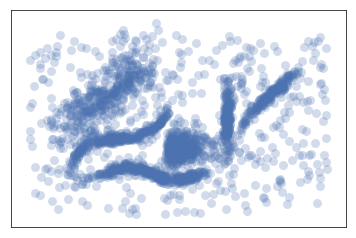

In [3]:
plt.scatter(data.T[0], data.T[1], c='b', **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [4]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

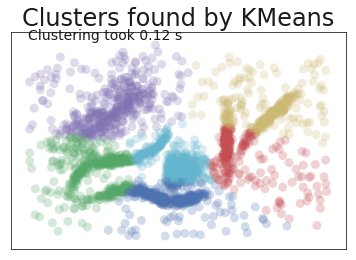

In [5]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':6})

* the assumption of perfectly globular clusters means that the natural clusters have been spliced and clumped into various more globular shapes
* the noise points get lumped into clusters as well: in some cases, due to where relative cluster centers ended up, points very distant from a cluster get lumped in
* Having noise pollute your clusters like this is particularly bad for EDA
* we completed clustering very quickly

# Benchmarking k-means for different `init` strategies

init strategy: choosing the intial centroids

In [9]:
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)

digits = load_digits()
data = scale(digits.data)

n_samples, n_features = data.shape
n_digits = len(np.unique(digits.target))
labels = digits.target

sample_size = 300

print("n_digits: %d, \t n_samples %d, \t n_features %d"
      % (n_digits, n_samples, n_features))


print(79 * '_')
print('% 9s' % 'algorithm'
      '    time  inertia    homo   compl  v-meas     ARI   AMI  silhouette')


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f'
          % (name, (time() - t0), estimator.inertia_,
             metrics.homogeneity_score(labels, estimator.labels_),
             metrics.completeness_score(labels, estimator.labels_),
             metrics.v_measure_score(labels, estimator.labels_),
             metrics.adjusted_rand_score(labels, estimator.labels_),
             metrics.adjusted_mutual_info_score(labels,  estimator.labels_),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))

bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
              name="k-means++", data=data)

bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
              name="random", data=data)

# in this case the seeding of the centers is deterministic, hence we run the
# kmeans algorithm only once with n_init=1
pca = PCA(n_components=n_digits).fit(data)
bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
              name="PCA-based",
              data=data)
print(79 * '_')

n_digits: 10, 	 n_samples 1797, 	 n_features 64
_______________________________________________________________________________
algorithm    time  inertia    homo   compl  v-meas     ARI   AMI  silhouette
k-means++   0.22s    69432   0.602   0.650   0.625   0.465   0.598    0.146
   random   0.19s    69694   0.669   0.710   0.689   0.553   0.666    0.147
PCA-based   0.03s    70804   0.671   0.698   0.684   0.561   0.668    0.118
_______________________________________________________________________________


## How can we interpret these scores without knowing anything about these metrics?

Think about the conventions in sklearn.

* [Clustering Evaluation Metrics](http://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation)
* Similar interpretation everywhere
    - Perfect labeling is scored 1
    - Bad (e.g. independent labelings) have negative or close to 0.0 scores
    - Typical ranges [0, 1] or [-1, 1]
    
# Visualize the results on PCA-reduced data:

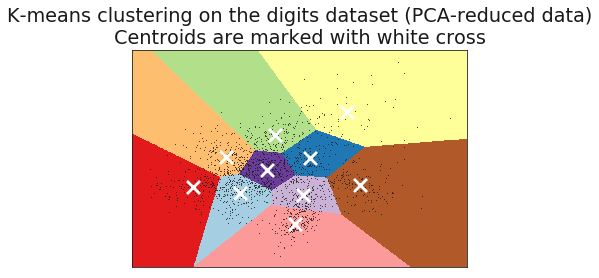

In [7]:
reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()